In [22]:

import pandas_datareader as pdr
import pandas as pd
import math
import matplotlib.pyplot as plt
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM

## Collecting Data

In [2]:
# df = pdr.get_data_tiingo('MRO', api_key=key)
# df.to_csv('MRO.csv')

In [3]:
df = pd.read_csv('MRO.csv')
df.head()

,symbol,date,close,high,low,open,volume,adjClose,adjHigh,adjLow,adjOpen,adjVolume,divCash,splitFactor
0,MRO,2017-05-31 00:00:00+00:00,13.02,13.10,12.75,12.92,14540830,12.211546,12.286579,11.958311,12.117756,14540830,0.0,1.0
1,MRO,2017-06-01 00:00:00+00:00,13.10,13.41,12.95,13.05,11547207,12.286579,12.577330,12.145893,12.239683,11547207,0.0,1.0
2,MRO,2017-06-02 00:00:00+00:00,12.72,12.99,12.56,12.96,13797001,11.930174,12.183409,11.780109,12.155272,13797001,0.0,1.0
3,MRO,2017-06-05 00:00:00+00:00,12.78,12.86,12.54,12.61,10988204,11.986449,12.061481,11.761351,11.827004,10988204,0.0,1.0
4,MRO,2017-06-06 00:00:00+00:00,12.88,12.96,12.64,12.76,10639213,12.080239,12.155272,11.855142,11.967690,10639213,0.0,1.0


In [4]:
df1 = df.reset_index()['close']
df1.shape

(1259,)

In [5]:
df1.head()

0    13.02
1    13.10
2    12.72
3    12.78
4    12.88
Name: close, dtype: float64

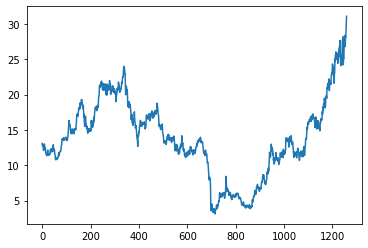

In [6]:
plt.plot(df1)

In [7]:
scaler = MinMaxScaler(feature_range=(0,1))
df1 = scaler.fit_transform(np.array(df1).reshape(-1,1))
df1

array([[0.35420394],
       [0.35706619],
       [0.34347048],
       ...,
       [0.92629696],
       [0.95277281],
       [1.        ]])

## Splitting Data for Training and Testing

In [8]:
train_size = int(len(df1)*0.65)
test_size = len(df1) - train_size
train_data, test_data = df1[0:train_size,:], df1[train_size:len(df1),:1]
len(train_data), len(test_data)

(818, 441)

## Preprocessing

In [9]:
def create_data_matrix(dataset, time_step=1):
    dataX, dataY = [], []
    for i in range(len(dataset) - time_step-1):
        a = dataset[i:(i+time_step), 0]
        dataX.append(a)
        dataY.append(dataset[i + time_step, 0])
    return np.array(dataX), np.array(dataY)

In [10]:
time_step = 100
X_train, y_train = create_data_matrix(train_data, time_step)
X_test, y_valid = create_data_matrix(test_data, time_step)

In [11]:
print(X_train.shape), print(y_train.shape)
print(X_test.shape), print(y_train.shape)

(717, 100)
(717,)
(340, 100)
(717,)


(None, None)

In [12]:
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)

## Implementing Stacked LSTM Model

In [15]:
model = Sequential()
model.add(LSTM(50, return_sequences=True, input_shape=(100,1)))
model.add(LSTM(50, return_sequences=True))
model.add(LSTM(50))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')

In [16]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 100, 50)           10400     
                                                                 
 lstm_1 (LSTM)               (None, 100, 50)           20200     
                                                                 
 lstm_2 (LSTM)               (None, 50)                20200     
                                                                 
 dense (Dense)               (None, 1)                 51        
                                                                 
Total params: 50,851
Trainable params: 50,851
Non-trainable params: 0
_________________________________________________________________


In [17]:
model.fit(X_train, y_train, validation_data=(X_test, y_valid), epochs=100, batch_size=64, verbose=1)

Epoch 1/100
12/12 [==============================] - 7s 222ms/step - loss: 0.0658 - val_loss: 0.0115
Epoch 2/100
12/12 [==============================] - 2s 129ms/step - loss: 0.0108 - val_loss: 0.0057
Epoch 3/100
12/12 [==============================] - 2s 135ms/step - loss: 0.0060 - val_loss: 0.0091
Epoch 4/100
12/12 [==============================] - 2s 136ms/step - loss: 0.0034 - val_loss: 0.0040
Epoch 5/100
12/12 [==============================] - 2s 135ms/step - loss: 0.0024 - val_loss: 0.0022
Epoch 6/100
12/12 [==============================] - 2s 139ms/step - loss: 0.0021 - val_loss: 0.0023
Epoch 7/100
12/12 [==============================] - 2s 133ms/step - loss: 0.0020 - val_loss: 0.0020
Epoch 8/100
12/12 [==============================] - 2s 134ms/step - loss: 0.0020 - val_loss: 0.0021
Epoch 9/100
12/12 [==============================] - 2s 139ms/step - loss: 0.0019 - val_loss: 0.0018
Epoch 10/100
12/12 [==============================] - 2s 139ms/step - loss: 0.0018 - val_lo

## Predict

In [18]:
train_predict = model.predict(X_train)
test_predict = model.predict(X_test)

11/11 [==============================] - 0s 20ms/step


In [19]:
train_predict = scaler.inverse_transform(train_predict)
test_predict = scaler.inverse_transform(test_predict)

## Calculate RMSE and Plot Data

In [23]:
math.sqrt(mean_squared_error(y_train, train_predict))

14.076174845277075

In [24]:
math.sqrt(mean_squared_error(y_valid, test_predict))

15.49761958745565

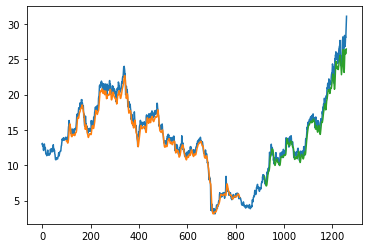

In [25]:
trainPredictPlot= np.empty_like(df1)
trainPredictPlot[:,:] = np.nan
trainPredictPlot[time_step:len(train_predict)+time_step, :] = train_predict

testPredictPlot = np.empty_like(df1)
testPredictPlot[:,:] = np.nan
testPredictPlot[len(train_predict)+time_step*2 + 1: len(df1)-1, :] = test_predict

plt.plot(scaler.inverse_transform(df1))
plt.plot(trainPredictPlot)
plt.plot(testPredictPlot)
plt.show()